In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Linear, MSELoss, Sigmoid

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("darkgrid")

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## define the dataset and model class

In [2]:
class OOIDASDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        'Initialization'
        self.inputs = inputs.astype(np.float32)
        self.outputs = outputs.astype(np.float32)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.outputs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.inputs[index, :]
        y = self.outputs[index, :]

        return X, y

class RandomFourierFeatureNetwork(torch.nn.Module):
    def __init__(self, nfeature):
        super().__init__()
#         self.input = Flatten()
        self.ln1 = Linear(2*nfeature, nfeature)
        self.ln2 = Linear(nfeature, nfeature)
        self.ln3 = Linear(nfeature, nfeature)
        self.ln4 = Linear(nfeature, nfeature)
        self.ln5 = Linear(nfeature, nfeature)
        self.output = Linear(nfeature, 1)
        self.sigmoid = Sigmoid()
        self.relu = torch.relu
        
    def forward(self, x):
#         x = self.input(x)
        x = self.relu(self.ln1(x))
        x = self.relu(self.ln2(x))
        x = self.relu(self.ln3(x))
        x = self.relu(self.ln4(x))
        x = self.relu(self.ln5(x))
        x = self.sigmoid(self.output(x))
        return x

## load data

In [3]:
DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-15min-demean-15-29-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::8,::8]
TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

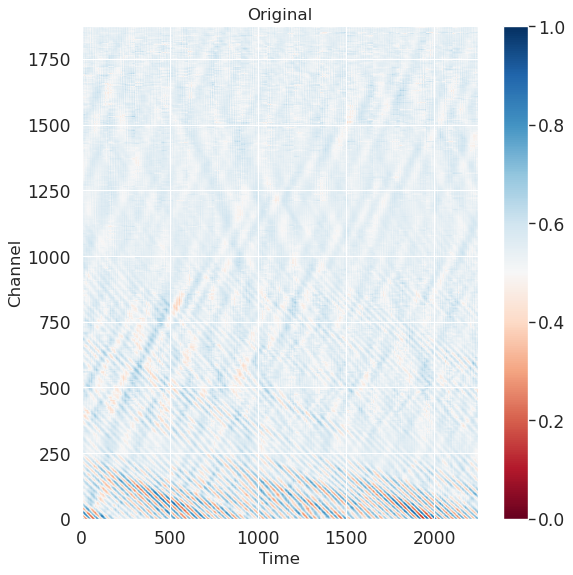

In [4]:
fig = plt.figure(figsize = (8, 8), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

## preprocessing data and send to data loader

In [5]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); X = x/(NX-1)

nfeature = 196
B = np.random.normal(scale = 20, size = (nfeature, 2))

# nfeature = 2
# B = np.eye(2)

Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)@B.T
all_data = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv), TRAIN_DATA.reshape([-1, 1])], axis = -1)

print(T.shape, X.shape, all_data.shape)

dataset = OOIDASDataset(all_data[:, :-1], np.expand_dims(all_data[:, -1], axis = -1))
data_loader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=10)

(1875, 2250) (1875, 2250) (4218750, 393)


## defind model and initize the weights

In [6]:
device = torch.device('cuda')
model = RandomFourierFeatureNetwork(nfeature)
for i in model.modules():
    if isinstance(i, Linear):
        i.weight.data.normal_(mean=0.0, std=0.1)
        i.bias.data.normal_(mean=0.0, std=0.1)

model.to(device);

In [7]:
nweights = 0
for i in model.modules():
    if isinstance(i, Linear):
        nweights += len(i.weight.data.flatten())
        nweights += len(i.bias.data.flatten())
print(f"have total {nweights}")

have total 231673


## training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)
loss_fn = MSELoss()

In [9]:
nepoch = 40
train_losses = []
for t in range(nepoch):
    print(f"Epoch {t+1}")
    ## train
    model.train()
    train_loss = 0
    
    for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
        pred = model(batch[0].to(device))
        loss = loss_fn(pred, batch[1].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(data_loader)
    train_losses.append(train_loss)
    print("train loss %.6f"  % (train_loss))

Epoch 1


100%|██████████| 1030/1030 [00:07<00:00, 145.16it/s]

train loss 0.00239
Epoch 2



100%|██████████| 1030/1030 [00:06<00:00, 170.28it/s]

train loss 0.00111
Epoch 3



100%|██████████| 1030/1030 [00:06<00:00, 167.63it/s]

train loss 0.00095
Epoch 4



100%|██████████| 1030/1030 [00:06<00:00, 147.20it/s]

train loss 0.00089
Epoch 5



100%|██████████| 1030/1030 [00:06<00:00, 167.30it/s]

train loss 0.00086
Epoch 6



100%|██████████| 1030/1030 [00:06<00:00, 170.47it/s]

train loss 0.00084
Epoch 7



100%|██████████| 1030/1030 [00:06<00:00, 170.16it/s]

train loss 0.00083
Epoch 8



100%|██████████| 1030/1030 [00:06<00:00, 157.95it/s]

train loss 0.00082
Epoch 9



100%|██████████| 1030/1030 [00:06<00:00, 149.93it/s]

train loss 0.00080
Epoch 10



100%|██████████| 1030/1030 [00:06<00:00, 149.70it/s]

train loss 0.00079
Epoch 11



100%|██████████| 1030/1030 [00:06<00:00, 151.07it/s]

train loss 0.00078
Epoch 12



100%|██████████| 1030/1030 [00:06<00:00, 163.19it/s]

train loss 0.00078
Epoch 13



100%|██████████| 1030/1030 [00:06<00:00, 164.85it/s]

train loss 0.00077
Epoch 14



100%|██████████| 1030/1030 [00:06<00:00, 166.71it/s]

train loss 0.00076
Epoch 15



100%|██████████| 1030/1030 [00:07<00:00, 147.14it/s]

train loss 0.00076
Epoch 16



100%|██████████| 1030/1030 [00:06<00:00, 159.74it/s]

train loss 0.00075
Epoch 17



100%|██████████| 1030/1030 [00:06<00:00, 154.83it/s]

train loss 0.00075
Epoch 18



100%|██████████| 1030/1030 [00:07<00:00, 145.87it/s]

train loss 0.00074
Epoch 19



100%|██████████| 1030/1030 [00:06<00:00, 162.69it/s]

train loss 0.00074
Epoch 20



100%|██████████| 1030/1030 [00:06<00:00, 166.82it/s]

train loss 0.00074
Epoch 21



100%|██████████| 1030/1030 [00:06<00:00, 163.94it/s]

train loss 0.00073
Epoch 22



100%|██████████| 1030/1030 [00:06<00:00, 161.05it/s]

train loss 0.00073
Epoch 23



100%|██████████| 1030/1030 [00:06<00:00, 158.03it/s]

train loss 0.00073
Epoch 24



100%|██████████| 1030/1030 [00:06<00:00, 162.58it/s]

train loss 0.00072
Epoch 25



100%|██████████| 1030/1030 [00:06<00:00, 156.98it/s]

train loss 0.00072
Epoch 26



100%|██████████| 1030/1030 [00:06<00:00, 156.33it/s]

train loss 0.00072
Epoch 27



100%|██████████| 1030/1030 [00:06<00:00, 155.72it/s]

train loss 0.00071
Epoch 28



100%|██████████| 1030/1030 [00:06<00:00, 170.65it/s]

train loss 0.00071
Epoch 29



100%|██████████| 1030/1030 [00:06<00:00, 162.21it/s]

train loss 0.00071
Epoch 30



100%|██████████| 1030/1030 [00:06<00:00, 169.31it/s]

train loss 0.00071
Epoch 31



100%|██████████| 1030/1030 [00:06<00:00, 166.16it/s]

train loss 0.00070
Epoch 32



100%|██████████| 1030/1030 [00:06<00:00, 154.54it/s]

train loss 0.00070
Epoch 33



100%|██████████| 1030/1030 [00:06<00:00, 154.50it/s]

train loss 0.00070
Epoch 34



100%|██████████| 1030/1030 [00:06<00:00, 158.64it/s]

train loss 0.00070
Epoch 35



100%|██████████| 1030/1030 [00:06<00:00, 159.17it/s]

train loss 0.00069
Epoch 36



100%|██████████| 1030/1030 [00:06<00:00, 158.32it/s]

train loss 0.00069
Epoch 37



100%|██████████| 1030/1030 [00:06<00:00, 167.12it/s]

train loss 0.00069
Epoch 38



100%|██████████| 1030/1030 [00:06<00:00, 168.14it/s]

train loss 0.00069
Epoch 39



100%|██████████| 1030/1030 [00:06<00:00, 171.03it/s]

train loss 0.00069
Epoch 40



100%|██████████| 1030/1030 [00:06<00:00, 170.37it/s]

train loss 0.00068


Text(0, 0.5, 'Training loss')

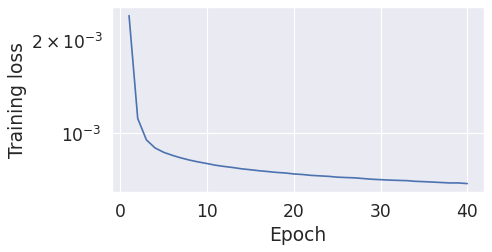

In [10]:
plt.figure(figsize = (6, 3), dpi = 80)
plt.plot(np.arange(1, 40 + 1), train_losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [20]:
predict = model(torch.Tensor(all_data[:, :-1]).to(device)).reshape(NX, NT)
predict = predict.detach().cpu()
predict = predict.numpy()
torch.cuda.empty_cache()

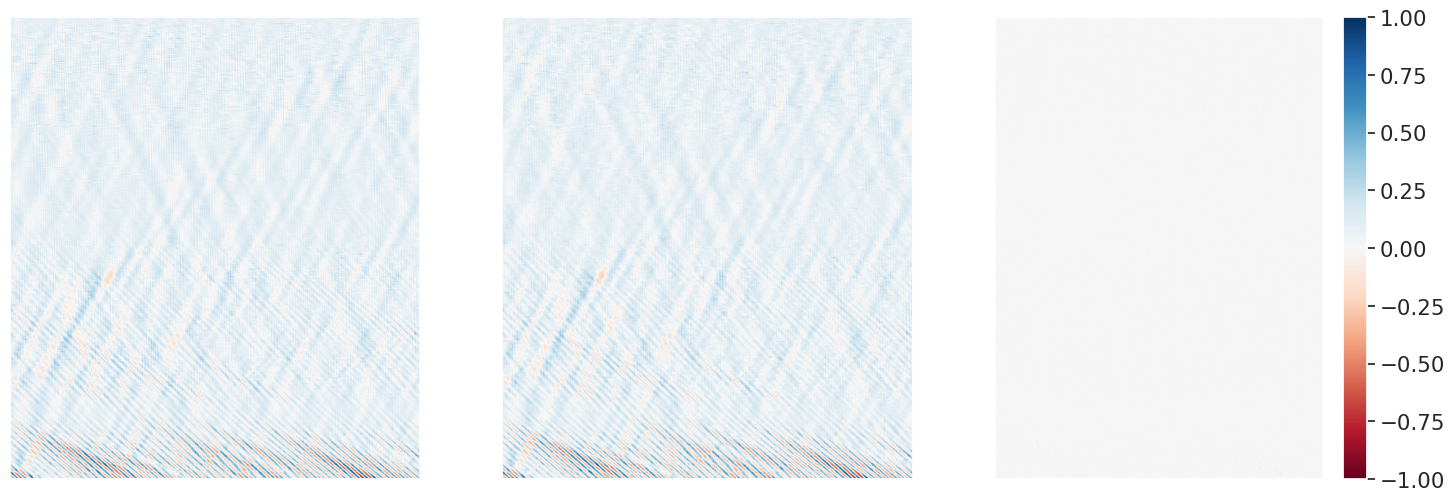

In [21]:
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -1, vmax = 1)
plt.xticks([]); plt.yticks([])
plt.colorbar()